# Do better postprocessing with 2d segmentation

## First, segment

In [6]:
# %load_ext line_profiler
%load_ext autoreload
%autoreload 2

from segmentation.util.utils_pipeline import segment_video_using_config_2d
from DLC_for_WBFM.utils.projects.utils_project import load_config, safe_cd
from pathlib import Path
import zarr
import os
from magicgui import magicgui
import numpy as np
from tqdm.auto import tqdm
from napari.types import LayerDataTuple
import skimage
import scipy
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
import zarr, napari

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# project_fname = r'Y:\shared_projects\wbfm\dlc_stacks\Charlie-gfp2d\project_config.yaml'
# project_fname = r'Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-new-seg\project_config.yaml'
project_fname = r"C:\dlc_stacks\Charlie-worm3-new-seg\project_config.yaml"

project_cfg = load_config(project_fname)
segment_fname = project_cfg['subfolder_configs']['segmentation']
project_dir = Path(project_fname).parent
with safe_cd(project_dir):
    segment_cfg = load_config(segment_fname)

this_config = segment_cfg.copy()
this_config['dataset_params'] = project_cfg['dataset_params'].copy()

In [3]:
this_config['dataset_params']['num_frames'] = 3
n = this_config['dataset_params']['num_frames']
print(f"Will analyze {n} frames")

Will analyze 3 frames


In [4]:
# with safe_cd(project_dir):
#     segment_video_using_config_2d(this_config)

## Second, visualize

In [7]:
i_start = project_cfg['dataset_params']['start_volume']
n = 3
i_end = i_start + n

In [8]:
red_fname = project_cfg['preprocessed_red']
red_dat = zarr.open(red_fname)[i_start:i_end]

project_dir = Path(project_fname).parent
with safe_cd(project_dir):
    segment_cfg = load_config(segment_fname)
    seg_fname = segment_cfg['output']['masks']
    
    seg_dat = zarr.open(seg_fname)

In [9]:
viewer = napari.view_image(red_dat)
viewer.add_labels(seg_dat)

vispy_camera.py (109): divide by zero encountered in true_divide


<Labels layer 'seg_dat' at 0x2afcc79aa88>

In [10]:
seg_fname

'1-segmentation\\masks_1500-watershed.zarr'

## Third, apply some postprocessing

In [27]:

tmp_seg = np.array(seg_dat[:5,...])

In [11]:
all_neuron_masks = []
all_neuron_dat = []
tmp_seg = np.array(seg_dat[0,...])
vals = np.unique(tmp_seg)
r = red_dat[0,...]
for v in tqdm(vals[1:]):
    mask = tmp_seg == v
    if len(np.nonzero(mask)) == 0:
        continue
    dat = r[mask]
    
    all_neuron_masks.append(mask)
    all_neuron_dat.append(dat)

set_zero = np.frompyfunc(lambda x: 0, 1, 1)

  0%|          | 0/149 [00:00<?, ?it/s]

In [28]:
@magicgui(
    call_button="Apply Global Threshold",
    threshold={"widget_type": "IntSlider", 'max': 100})
def apply_global_threshold(viewer: napari.Viewer, threshold: int = 0) -> LayerDataTuple:
    bright_pixels = viewer.layers['red_dat'].data > threshold
    seg_dat = viewer.layers['seg_dat'].data
    seg_dat = np.where(bright_pixels, seg_dat, 0)
    
    print("Finished")
    
    return (seg_dat, {'name': 'Thresholded_masks'}, 'labels')

@magicgui(
    call_button="Apply per-neuron Quantile Threshold",
    quant_thresh={"widget_type": "FloatSlider", 'max': 1.0})
def apply_quantile_threshold(viewer: napari.Viewer, quant_thresh: float = 0.0) -> LayerDataTuple:
    seg_dat_raw = viewer.layers['seg_dat'].data[0,...]
    seg_dat = seg_dat_raw.copy()
    red_dat = viewer.layers['red_dat'].data[0,...]
    for r, m in tqdm(zip(all_neuron_dat, all_neuron_masks), total=len(all_neuron_dat), leave=False):
        threshold = np.quantile(r, quant_thresh)
        dim_pixels = r < threshold
        
        linear_ind = np.ravel_multi_index(np.where(m), m.shape)
        ind_to_zero = np.unravel_index(linear_ind[dim_pixels], m.shape)
        set_zero.at(seg_dat, ind_to_zero)

    print("Removing small objects...")
    seg_dat = skimage.morphology.remove_small_objects(seg_dat, 30, connectivity=1)
    label_dat = skimage.morphology.label(seg_dat)
    print("Recaculating centroids...")
    properties = skimage.measure.regionprops(label_dat, red_dat)
    seeds = []
    for p in properties:
        seeds.append([round(val) for val in p['weighted_local_centroid']])
    seed_mask = np.zeros_like(seg_dat, dtype=bool)
    for s in seeds:
        seed_mask[s] = True
    print("Resegmenting using watershed...")
    final_labels = watershed(255-red_dat, seed_mask, mask=seg_dat_raw.astype(bool))
    print("Finished quantile mask calculation")
    
    return [(final_labels, {'name': 'Quantile_masks'}, 'labels'), 
            (seed_mask, {'name': 'seeds for quantile watershed'}, 'labels')]


@magicgui(
    call_button="Apply distance transform and watershed")
def apply_distance_transform(viewer: napari.Viewer, sigma=1) -> LayerDataTuple:
    seg_dat_raw = viewer.layers['seg_dat'].data[0,...]
    seg_dat = seg_dat_raw.copy()
    red_dat = viewer.layers['red_dat'].data[0,...]
    
    # Filter the brightness
    filtered_red = skimage.filters.gaussian(red_dat, sigma=sigma)
    
    # Now we want to separate the two objects in image
    # Generate the markers as local maxima of the distance to the background
    print("Applying distance transform...")
    distance = ndi.distance_transform_edt(seg_dat)
    distance_times_brightness = np.multiply(distance, filtered_red)
    coords = peak_local_max(distance_times_brightness, footprint=np.ones((5, 11, 11)), labels=seg_dat, num_peaks_per_label=3)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    print("Resegmenting using watershed...")
    labels = watershed(-distance, markers, mask=seg_dat)
    print("Finished distance transform mask calculation")
    
    return [(labels, {'name': 'Distance_masks'}, 'labels'), 
            (mask, {'name': 'seeds for distance watershed'}, 'labels'),
            (filtered_red, {'name': 'filtered_red'}, 'image')]

In [29]:
viewer = napari.view_image(red_dat)
viewer.add_labels(tmp_seg, name="seg_dat")

vispy_camera.py (109): divide by zero encountered in true_divide


<Labels layer 'seg_dat' at 0x2afe1965788>

In [ ]:
viewer.window.add_dock_widget(apply_global_threshold)
viewer.window.add_dock_widget(apply_distance_transform)
viewer.window.add_dock_widget(apply_quantile_threshold)

# Alternate: just use the u-net component of stardist

In [71]:
from segmentation.util.utils_model import get_stardist_model
import numpy as np
from segmentation.util.utils_postprocessing import remove_dim_slices
from csbdeep.utils import Path, normalize
from stardist.geometry import _dist_to_coord_old as dist_to_coord
from stardist.nms import _non_maximum_suppression_old as non_maximum_suppression
from stardist.geometry import _polygons_to_label_old as polygons_to_label
import matplotlib.pyplot as plt
# from stardist import random_label_cmap

# lbl_cmap = random_label_cmap()
from skimage.transform import resize
import skimage
import scipy
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import clear_border, find_boundaries

In [11]:
vol = red_dat[0,...]

stardist_model_name = 'lukas'
sd_model = get_stardist_model(stardist_model_name)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.458531, nms_thresh=0.4.


In [12]:
# def segment_with_stardist_unet(vol, model):
#     # See: segment_with_stardist_2d
#     # initialize output dimensions and other variables
#     z = len(vol)
#     xy = vol.shape[1:]
# #     segmented_masks = np.zeros((z, *xy))    # '*' = tuple unpacking
#     all_prob = np.zeros_like(vol, dtype=float)    # '*' = tuple unpacking
#     axis_norm = (0, 1)
#     n_channel = 1

#     # iterate over images to run stardist on single images
#     for idx, plane in enumerate(vol):
#         img = plane

#         # normalizing images (stardist function)
#         img = normalize(img, 1, 99.8, axis=axis_norm)

#         # run the prediction
# #         labels, details = model.predict_instances(img)
#         out = model.predict(img)
#         prob, dist = out
# #         print(prob.shape)
# #         coord = dist_to_coord(dist, grid=model.config.grid)
# #         points = non_maximum_suppression(coord,prob, prob_thresh=0.4, grid=model.config.grid)
# #         labels = polygons_to_label(coord,prob,points, shape=img.shape)

#         # save labels in 3D array for output
# #         segmented_masks[idx] = labels
#         all_prob[idx,...] = resize(prob, xy)
# #         print(np.max(prob))

#     return all_prob

In [75]:
def segment_with_stardist_full(vol, model):
    # See: segment_with_stardist_2d
    # initialize output dimensions and other variables
    z = len(vol)
    xy = vol.shape[1:]
    segmented_masks = np.zeros_like(vol)    # '*' = tuple unpacking
    boundary = np.zeros_like(segmented_masks, dtype='bool')
    axis_norm = (0, 1)
    n_channel = 1

    # iterate over images to run stardist on single images
    for idx, plane in enumerate(vol):
        img = plane

        # normalizing images (stardist function)
        img = normalize(img, 1, 99.8, axis=axis_norm)

        # run the prediction
        labels, details = model.predict_instances(img)
        
        # Remove border-touching elements (almost certainly rotation artifacts)
        labels = clear_border(labels, buffer_size=20)
        
        # Postprocess to add separation between labels
        # From: watershed.py in 3DeeCellTracker
        labels_bd = find_boundaries(labels, connectivity=2, mode='outer', background=0)

        boundary[idx, :, :] = labels_bd

        # save labels in 3D array for output
        segmented_masks[idx] = labels

    segmented_masks[boundary==1] = 0
    
    remove_dim_slices(segmented_masks, vol)
    
    return segmented_masks

In [87]:

def stitch_via_watershed(seg_dat, red_dat, sigma=1):
    
    # Filter the brightness
    filtered_red = skimage.filters.gaussian(red_dat, sigma=sigma)
    
    # Now we want to separate the two objects in image
    # Generate the markers as local maxima of the distance to the background
    print("Applying distance transform...")
    distance = ndi.distance_transform_edt(seg_dat.astype(bool))
    distance_times_brightness = np.multiply(distance, filtered_red)
    coords = peak_local_max(distance_times_brightness, footprint=np.ones((5, 11, 11)))
#     coords = peak_local_max(distance_times_brightness, footprint=np.ones((5, 11, 11)), labels=seg_dat, num_peaks_per_label=3)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    print("Resegmenting using watershed...")
    labels = watershed(-distance, markers, mask=seg_dat)
    print("Finished distance transform mask calculation")
    
    return labels, mask

In [77]:
%%time
unet_result = segment_with_stardist_full(vol, sd_model)

Wall time: 33.5 s


In [88]:
%%time
# Join via "watershed stitching"
stitched_result, seeds = stitch_via_watershed(unet_result, vol, sigma=2)

Applying distance transform...
Resegmenting using watershed...
Finished distance transform mask calculation
Wall time: 7.7 s


In [92]:
viewer = napari.view_image(vol)
viewer.add_labels(unet_result)
viewer.add_labels(stitched_result)
viewer.add_labels(seeds)

vispy_camera.py (109): divide by zero encountered in true_divide


<Labels layer 'Labels' at 0x1e60dd15208>

# Check results from full function call

In [93]:
fname = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-new-seg\1-segmentation\masks_3.zarr"
function_seg = zarr.open(fname)

In [94]:
viewer = napari.view_image(red_dat)
viewer.add_labels(function_seg)

vispy_camera.py (109): divide by zero encountered in true_divide


<Labels layer 'function_seg' at 0x1e605414588>

# Look at details of the stardist steps

In [42]:

axis_norm = (0,1)   # normalize channels independently


In [43]:
%%time
# 1.
%time img = normalize(vol[16], 1,99.8, axis=axis_norm)
# 2.
%time prob, dist = sd_model.predict(img)
# 3.
%time coord = dist_to_coord(dist, grid=sd_model.config.grid)
# 4.
%time points = non_maximum_suppression(coord,prob, prob_thresh=0.4, grid=sd_model.config.grid)
# 5.
%time labels = polygons_to_label(coord,prob,points, shape=img.shape)
print('------------------')

Wall time: 15.6 ms
Wall time: 729 ms
Wall time: 184 ms
Wall time: 10.1 ms
Wall time: 8.07 ms
------------------
Wall time: 947 ms


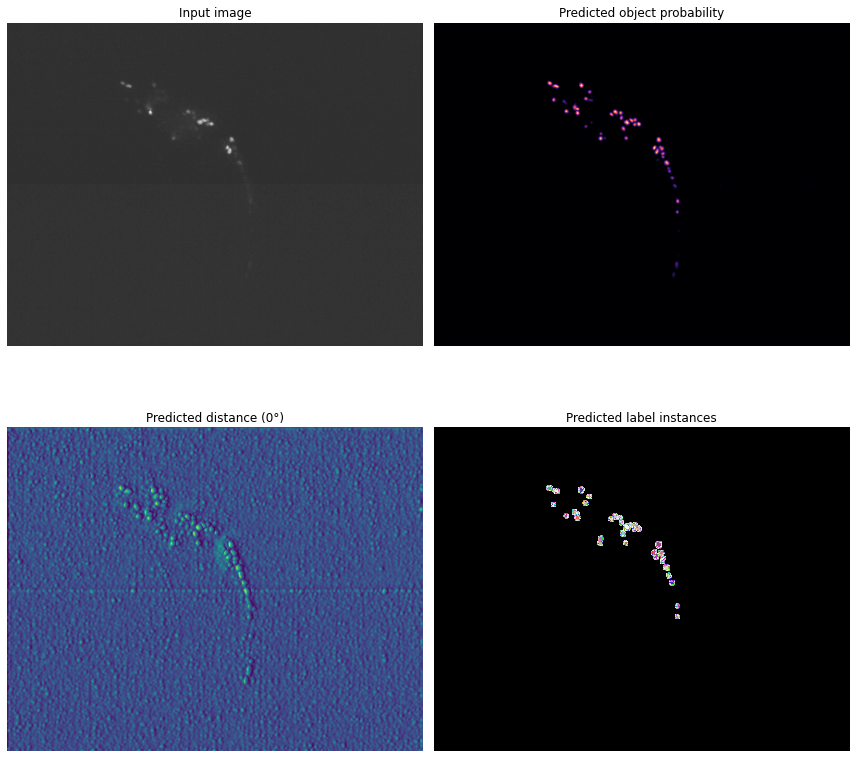

In [48]:
img_show = img if img.ndim==2 else img[...,:3]
fig, ax = plt.subplots(2,2, figsize=(12,12))
for a,d,cm,s in zip(ax.flat, [img_show,prob,dist[...,0],labels], ['gray','magma','viridis',lbl_cmap],
                    ['Input image','Predicted object probability','Predicted distance (0°)','Predicted label instances']):
    a.imshow(d,cmap=cm)
    a.set_title(s)
    a.axis('off')
plt.tight_layout()
None;

In [53]:
prob.shape, img_show.shape, dist[...,0].shape, labels.shape

((350, 450), (700, 900), (350, 450), (700, 900))

In [52]:
sd_model

StarDist2D(stardistNiklas): YXC → YXC
├─ Directory: \\storage.imp.ac.at\groups\zimmer\shared_projects\wbfm\TrainedStardist\stardistNiklas
└─ Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_classes=None, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=[1, 0.2], train_n_val_patches=None, train_patch_size=[256, 256], train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel